In [21]:
# импорт библиотек

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [22]:
df = pd.read_csv('train_2.csv', low_memory=False)

In [23]:
# смотрим на названия столбцов (не используем .head() из-за слишком большого числа столбцов) 
df.iloc[0]

Unnamed: 0                                                                    0
ticket_id                                                                 22056
agency_name                      Buildings, Safety Engineering & Env Department
inspector_name                                                  Sims, Martinzie
violator_name                                 INVESTMENT INC., MIDWEST MORTGAGE
violation_street_number                                                    2900
violation_street_name                                                     TYLER
violation_zip_code                                                          NaN
mailing_address_str_number                                                    3
mailing_address_str_name                                              S. WICKER
city                                                                    CHICAGO
state                                                                        IL
zip_code                                

In [24]:
# ticker_id связан с адресами
df1 = pd.read_csv('addresses.csv')
df1.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [25]:
# адреса связаны с координатами
df2 = pd.read_csv('latlons.csv')
df2.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [26]:
# чтобы не путаться в трех датафреймах, соединим их в один, использую merge()
# она добавляет новые столбцы «умно», связывая строки по одинаковым значениям из столбцов с одинаковыми именами
res = df.merge(df1).merge(df2)
print(res.shape)
res.iloc[0]

(225000, 38)


Unnamed: 0                                                                    0
ticket_id                                                                 22056
agency_name                      Buildings, Safety Engineering & Env Department
inspector_name                                                  Sims, Martinzie
violator_name                                 INVESTMENT INC., MIDWEST MORTGAGE
violation_street_number                                                    2900
violation_street_name                                                     TYLER
violation_zip_code                                                          NaN
mailing_address_str_number                                                    3
mailing_address_str_name                                              S. WICKER
city                                                                    CHICAGO
state                                                                        IL
zip_code                                

In [27]:
# признак violation_code выглядит интересным 
res['violation_code'].nunique()

216

In [28]:
# посмотрим на уникальные значения кодов нарушений
pd.set_option("display.max_rows", 216)
res['violation_code'].value_counts()

9-1-36(a)               92469
9-1-81(a)               41330
22-2-88                 28720
9-1-104                 18092
22-2-45                  5208
9-1-105                  4860
9-1-43(a) - (Dwellin     4252
9-1-110(a)               3994
22-2-22                  3755
9-1-103(C)               3278
19450901                 2947
22-2-43                  2744
22-2-88(b)               2253
22-2-17                  1940
22-2-83(a)(b)(c)          849
61-81.0100/32.0066        811
22-2-83                   633
9-1-43(a) - (Structu      598
9-1-206                   334
9-1-209                   310
22-2-21(b)                261
22-2-61                   259
61-5-21                   257
9-1-101                   247
9-1-107                   205
9-1-43(a) - (Stories      171
9-1-111                   169
20130901                  167
9-1-201(a)                165
22-2-88(a)                165
61-63.0100                153
22-2-38                   148
61-5-18                   144
9-1-205   

compliance        0.0       1.0        N
fine_amount                             
25.0         0.923780  0.076220   1312.0
50.0         0.909016  0.090984  16882.0
100.0        0.882815  0.117185  14780.0
125.0        0.944969  0.055031    636.0
200.0        0.906291  0.093709  10650.0
250.0        0.935715  0.064285  81668.0
300.0        0.972348  0.027652   3761.0
500.0        0.931855  0.068145   4916.0
750.0        0.929936  0.070064    157.0
1000.0       0.955645  0.044355   3720.0
1500.0       0.938776  0.061224    196.0
2500.0       0.968232  0.031768   1448.0
3500.0       0.979269  0.020731   3859.0
10000.0      0.994872  0.005128    195.0


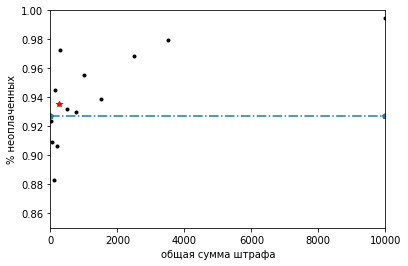

In [29]:
# построим сводную таблицу для размера штрафов и его уплаты/неуплаты 
col = 'fine_amount' 
cros = pd.crosstab(res[col], res['compliance'], normalize='index', margins=True)

# добавим столбец с числом выписанных штрафов на различные суммы
cros['N'] = res[(res['compliance'] == 1) | (res['compliance'] == 0)][col].value_counts() 

print(cros[cros['N'] > 100]) 

# построим график 
plt.plot(cros[cros['N'] > 100].index, cros[cros['N'] > 100][0], 'k.')

# красная звездочка - самая часто встречающаяся сумма выписываемых штрафов
maxind = cros['N'].idxmax()
plt.plot(maxind, cros.loc[maxind, 0], 'r*')

# пунктирная линия - средняя доля штрафов, которые не были оплачены 
aver = (cros[0]*cros['N']).sum()/cros['N'].sum()
plt.plot([0, np.max(res[col])], [aver, aver], 'p-.')
 
plt.axis((0, np.max(res[col]), .85, 1))
plt.xlabel('общая сумма штрафа')
plt.ylabel('% неоплаченных')

plt.show()

In [30]:
# аналогично построим сводную таблицу для названий компаний, которым выписывался штраф, и его факта уплаты/неуплаты
col = 'violator_name'
cros = pd.crosstab(res[col], res['compliance'], normalize='index', margins=True)

# подсчитаем количество штрафов, выписанных этим компаниям
cros['N'] = res[(res['compliance'] == 1) | (res['compliance'] == 0)][col].value_counts() 

print(cros[cros['N'] > 100].sort_values(by=['N'], ascending=False))

compliance                  0.0       1.0      N
violator_name                                   
INVESTMENT, ACORN      1.000000  0.000000  618.0
INVESTMENT CO., ACORN  1.000000  0.000000  343.0
BANK, WELLS FARGO      0.979675  0.020325  246.0
MILLER, JOHN           0.994083  0.005917  169.0
STEHLIK, JERRY         0.865385  0.134615  156.0
NEW YORK, BANK OF      0.971223  0.028777  139.0
KRAMER, KEITH          1.000000  0.000000  117.0
SNOW, GEORGE           1.000000  0.000000  108.0
APARTMENTS, CARLTON    1.000000  0.000000  102.0


In [31]:
# аналогично для кода нарушения и уплаты/неуплаты штрафа
col = 'violation_code'
cros  = pd.crosstab(res[col], res['compliance'], normalize='index', margins=True)

# сколько раз встречались следующие коды нарушений 
cros['N'] = res[(res['compliance'] == 1) | (res['compliance'] == 0)][col].value_counts() 

print(cros[cros['N'] > 100].sort_values(by=['N'], ascending=False))

compliance                 0.0       1.0        N
violation_code                                   
9-1-36(a)             0.924545  0.075455  60460.0
9-1-81(a)             0.967227  0.032773  21908.0
22-2-88               0.929114  0.070886  19073.0
9-1-104               0.919147  0.080853  13741.0
22-2-45               0.868434  0.131566   4074.0
9-1-105               0.911664  0.088336   3498.0
9-1-110(a)            0.881049  0.118951   2707.0
22-2-22               0.899694  0.100306   2612.0
9-1-43(a) - (Dwellin  0.977867  0.022133   2485.0
9-1-103(C)            0.851429  0.148571   2450.0
22-2-43               0.867284  0.132716   1944.0
19450901              0.971945  0.028055   1604.0
22-2-88(b)            0.949837  0.050163   1535.0
22-2-17               0.929279  0.070721   1414.0
22-2-83(a)(b)(c)      0.967611  0.032389    494.0
61-81.0100/32.0066    0.833713  0.166287    439.0
22-2-83               0.956772  0.043228    347.0
9-1-43(a) - (Structu  0.966967  0.033033    333.0


In [32]:
# определим признаки, по которым будем обучать модель 
feature_col = ['disposition', 'agency_name', 'late_fee', 'fine_amount','violation_description']

#удалим наблюдения, для которых штраф был выписан ошибочно
res = res.dropna(subset = ['compliance'])
df = res[feature_col]
# определим категориальные признаки, которые в дальнейшем нужно будет преобразовать
cate_col = ['disposition', 'agency_name', 'violation_description'] 

# определим вектор правильных ответов как столбец с указанием на уплату/неуплату штрафа
y = res['compliance']
X = df

# преобразуем категориальные признаки с помощью наивного кодирования
X_d = pd.get_dummies(X[cate_col])

# составим окончательную матрицу объектов-признаков
X_new = X[X.columns[np.in1d(X.columns, cate_col, invert=True)]].join(X_d)

In [33]:
# разбиение на обучающую и тестовые выборки 
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0, test_size=0.1)

In [37]:
scaler = RobustScaler(quantile_range=(25, 75))

# масштабируем как тренировочные, так и тестовые данные
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [38]:
# выбираем тип используемого классификатора
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)

In [39]:
# воспользуемся поиском по сетке гиперпараметров, чтобы выбрать оптимальные
grid_values = {'max_features': ['sqrt', 'log2'], 'max_depth':[4, 6, 8]}

# выбираем классификатор с оптимальными гиперпараметрами
grid_clf_auc = GridSearchCV(clf, param_grid=grid_values, scoring='roc_auc')
grid_clf_auc.fit(X_train_s, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
      

In [40]:
# наилучший результат по метрике площадь под roc кривой
print(grid_clf_auc.best_score_)

0.7992933451067092


In [41]:
clf2 = grid_clf_auc.best_estimator_
 
# применим классификатор с найденными гиперпараметрами к тестовой выборке
y_proba = clf2.predict_proba(X_test_s)
 
# вычислим roc-auc
roc_auc = roc_auc_score(y_test, y_proba[:,1])
 
# значение roc-auc после применения алгоритма к тестовой выборке
print('{:.3f}'.format(roc_auc))

0.792


In [42]:
# сделаем предсказания на тестовом наборе 
dft2 = pd.read_csv('test_2.csv')
dft2 = dft2.set_index('ticket_id')
Xt = dft2[feature_col]

# преобразуем категориальные признаки
Xt_d = pd.get_dummies(Xt[cate_col])
Xt_new = Xt[Xt.columns[np.in1d(Xt.columns, cate_col, invert=True)]].join(Xt_d)

# удалим лишние столбцы
iddel = np.in1d(Xt_new.columns, X_train.columns)
Xt_new2 = Xt_new[Xt_new.columns[iddel]]
Xt_new2.columns

# добавим столбцы в тестовый набор
idadd = np.in1d(X_train.columns, Xt_new2.columns, invert=True)
kwargs = {} 
for colname in X_train.columns[idadd]:
    kwargs[colname] = 0

Xt_new2 = Xt_new2.assign(**kwargs)

# масштабируем данные
Xt_s = scaler.transform(Xt_new2)

# сделаем предсказания
y_proba_t = clf2.predict_proba(Xt_s)

# сформируем выходные данные согласно требованиям: 
# матрица из двух колонок – id штрафа и вероятности его оплаты
ans = pd.Series(y_proba_t[:,1], index=Xt_new2.index, dtype='float32')
ans.name = 'compliance'


In [43]:
pd.DataFrame(ans).head()

,compliance
ticket_id,
259669,0.028734
259733,0.786591
258776,0.028734
258777,0.021583
259663,0.246609


In [44]:
#y_pred = clf2.predict(X_test_s)

In [45]:
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test, y_pred)

###  Добавление нового признака
###  Тестирование работы модели с учетом нового признака

In [46]:
# добавим новый признак, полученный как время в секундах между выпиской штрафа и датой слушания в суде

dres = res.copy()
dftest = dft2.copy()
tdiff = pd.to_datetime(res['hearing_date']) - pd.to_datetime(res['ticket_issued_date'])
dres['TimeDiff'] = tdiff.dt.total_seconds() / 86400
tdiff = pd.to_datetime(dft2['hearing_date']) - pd.to_datetime(dft2['ticket_issued_date'])
dftest['TimeDiff'] = tdiff.dt.total_seconds() / 86400
dftest.head()
res = dres

In [79]:
# определим признаки, по которым будем обучать модель 
feature_col = ['disposition', 'agency_name', 'late_fee', 'fine_amount','violation_description', 'TimeDiff']

#удалим наблюдения, для которых штраф был выписан ошибочно
res = res.dropna(subset = ['compliance'])
res = res.dropna(subset = ['TimeDiff'])
df = res[feature_col]
# определим категориальные признаки, которые в дальнейшем нужно будет преобразовать
cate_col = ['disposition', 'agency_name', 'violation_description'] 

# определим вектор правильных ответов как столбец с указанием на уплату/неуплату штрафа
y = res['compliance']
X = df

# преобразуем категориальные признаки с помощью наивного кодирования
X_d = pd.get_dummies(X[cate_col])

# составим окончательную матрицу объектов-признаков
X_new = X[X.columns[np.in1d(X.columns, cate_col, invert=True)]].join(X_d)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0, test_size=0.1)

In [81]:
scaler = RobustScaler(quantile_range=(25, 75))

# масштабируем как тренировочные, так и тестовые данные
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [82]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)

In [83]:
# воспользуемся поиском по сетке гиперпараметров, чтобы выбрать оптимальные
grid_values = {'max_features': ['sqrt', 'log2'], 'max_depth':[4, 6, 8]}

# выбираем классификатор с оптимальными гиперпараметрами
grid_clf_auc = GridSearchCV(clf, param_grid=grid_values, scoring='roc_auc')
grid_clf_auc.fit(X_train_s, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
      

In [84]:
print(grid_clf_auc.best_score_)

0.8091659285272073


In [85]:
clf2 = grid_clf_auc.best_estimator_
 
# применим классификатор с найденными гиперпараметрами к тестовой выборке
y_proba = clf2.predict_proba(X_test_s)
 
# вычислим roc-auc
roc_auc = roc_auc_score(y_test, y_proba[:,1])
 
# значение roc-auc после применения алгоритма к тестовой выборке
print('{:.3f}'.format(roc_auc))

0.810


Добавление нового признака увеличило значение метрики качества модели

In [91]:
# сделаем предсказания на тестовом наборе 
dft2 = dftest
dft2 = dft2.dropna(subset = ['TimeDiff'])

Xt = dft2[feature_col]

# преобразуем категориальные признаки
Xt_d = pd.get_dummies(Xt[cate_col])
Xt_new = Xt[Xt.columns[np.in1d(Xt.columns, cate_col, invert=True)]].join(Xt_d)

# удалим лишние столбцы
iddel = np.in1d(Xt_new.columns, X_train.columns)
Xt_new2 = Xt_new[Xt_new.columns[iddel]]
Xt_new2.columns

# добавим столбцы в тестовый набор
idadd = np.in1d(X_train.columns, Xt_new2.columns, invert=True)
kwargs = {} 
for colname in X_train.columns[idadd]:
    kwargs[colname] = 0

Xt_new2 = Xt_new2.assign(**kwargs)

# масштабируем данные
Xt_s = scaler.transform(Xt_new2)

# сделаем предсказания
y_proba_t = clf2.predict_proba(Xt_s)

# сформируем выходные данные согласно требованиям: 
# матрица из двух колонок – id штрафа и вероятности его оплаты
ans = pd.Series(y_proba_t[:,1], index=Xt_new2.index, dtype='float32')
ans.name = 'compliance'

###  Результат

In [97]:
pd.DataFrame(ans).head()

,compliance
ticket_id,
259669,0.035523
259733,0.818088
258776,0.133015
258777,0.307572
259663,0.273133


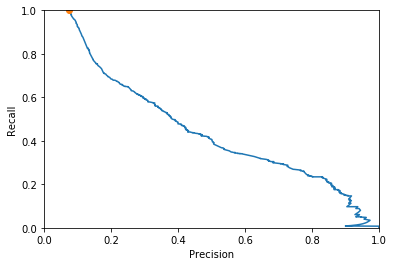

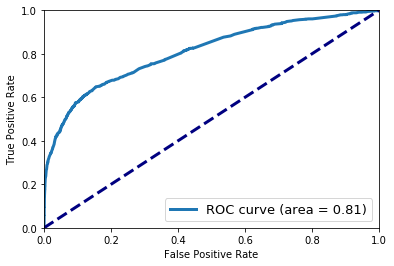

In [111]:
# pr кривая
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)

closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

# roc кривая
plt.figure()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

Результат получен. В этой работе в стороне остались географические признаки (например, классифицировать районы по состоянию помещений и благонадежности и использовать это как признак, но для этого нужна дополнительная информация). 